In [32]:
%matplotlib inline

import logging
import sys
import os
import copy

import numpy as np
import pylab
import matplotlib.pyplot as plt
import ogr
import fiona
import shapely.geometry, shapely.wkt
from shapely.ops import cascaded_union
from shapely.geometry import mapping

import shapely as sl
import networkx as nx

import rtree

from utils.shapely_plot import draw

pylab.rcParams['figure.figsize'] = (17.0, 15.0)
logging.basicConfig(stream=sys.stderr, level=logging.INFO)

In [2]:
def update_index(features, name):
    props = rtree.index.Property()
    props.dat_extension = 'data'
    props.idx_extension = 'index'
    idx = rtree.index.Index(name, properties = props, overwrite = True)
    
    for i, f in enumerate(features):
        idx.insert(i, f['geometry'].bounds, f)
        
    return idx

In [58]:
def find_largest_nearest(catchments, i, geom, index):
    """Finds the largerst nearest feature intersecting geom. Expects index to be RTree containing catchment features"""
    
    nearest_indices = list(index.intersection(geom.bounds))
    nearest_indices.remove(i) # remove this
        
    # collect all intersections
    nearest_intersections = []
    for i in nearest_indices:
        n = catchments[i]
            
        # refine intersection
        if geom.intersects(n['geometry']): 
            nearest_intersections.append((i, n))

    # find the largerst
    largest_nearest = None
    if nearest_intersections:
        nearest_intersections.sort(key=lambda x: x[1]['properties']['area'], reverse=True)

        largest_nearest = nearest_intersections[0]
        
    return largest_nearest

def connect_small_to_largest_nearest(catchments, index, max_area=0.00001, search_radius=0.002):
    """Finds largest neighbor catchments for all small catchments as directed graph"""

    results = nx.DiGraph() 
    
    for i, f in enumerate(catchments):
        if f['properties']['area'] < max_area:
            # hexagons around centroids
            buff = f['properties']['centroid'].buffer(search_radius, 6, 2)

            largest_nearest = find_largest_nearest(catchments, i, f['geometry'].buffer(0.0001), index)

            if find_largest_nearest:
                results.add_node(i, catchment=f)
                results.add_node(largest_nearest[0], catchment=largest_nearest[1])
                results.add_edge(i, largest_nearest[0])
    
    return results

def merge_leaf(catchments, merges):
    # merge every leaf with its neighbors
    leaf = [n for n,d in merges.out_degree().items() if d==0] # only leaf
    
    catchments = copy.deepcopy(catchments)
    
    for c in catchments:
        c['properties']['merged'] = False

    for n in leaf:
        catchment = catchments[n]
        
        geoms = [catchment['geometry']]
        
        for child in merges.predecessors(n):
            c = catchments[child]
            c['properties']['merged'] = True
            geoms.append(c['geometry'])
        
        geom = cascaded_union(shapely.geometry.MultiPolygon(geoms))
        
        catchment['geometry'] = geom
        
    for c in catchments:
        if not c['properties']['merged']:
            yield c


In [59]:
id = 4070030470.0

main_catchments = []

# new catchments (main)
path = r'../output/catchments_merge/SRTM_90_{0}_catchments.shp'.format(int(id))
print(path)
print('Reading main subcatchments ...')
with fiona.collection(path, "r") as features2:
    for i, f in enumerate(features2):
        g = shapely.geometry.shape(f['geometry'])
        f['properties']['centroid'] = g.centroid
        f['properties']['area'] = g.area
        
        if not g.is_valid:
            g = g.buffer(0)
        
        f['geometry'] = g
        
        main_catchments.append(f)

../output/catchments_merge/SRTM_90_4070030470_catchments.shp
Reading main subcatchments ...


In [60]:
print(len(main_catchments))

2702


In [61]:
index = update_index(main_catchments, 'idx_main')
to_merge1 = connect_small_to_largest_nearest(main_catchments, index)
merged1 = list(merge_leaf(main_catchments, to_merge1))
print(len(merged1))

1811


In [62]:
index = update_index(merged1, 'idx_main2')
to_merge2 = connect_small_to_largest_nearest(merged1, index)
merged2 = list(merge_leaf(merged1, to_merge2))
print(len(merged2))

1017


In [63]:
index = update_index(merged2, 'idx_main3')
to_merge3 = connect_small_to_largest_nearest(merged2, index)
merged3 = list(merge_leaf(merged2, to_merge3))
print(len(merged3))

523


In [64]:
index = update_index(merged3, 'idx_main4')
to_merge4 = connect_small_to_largest_nearest(merged3, index)
merged4 = list(merge_leaf(merged3, to_merge4))
print(len(merged4))

347


In [65]:
index = update_index(merged4, 'idx_main4')
to_merge5 = connect_small_to_largest_nearest(merged4, index)
merged5 = list(merge_leaf(merged4, to_merge5))
print(len(merged5))

323


In [66]:
index = update_index(merged5, 'idx_main5')
to_merge6 = connect_small_to_largest_nearest(merged5, index)
merged6 = list(merge_leaf(merged5, to_merge6))
print(len(merged6))

322


In [70]:
def write_shp(features, shp_path):
    schema = { 'geometry': 'Polygon', 'properties': {'DN': 'int'}, }

    with fiona.open(shp_path, 'w', 'ESRI Shapefile', schema) as c:
        for f in features:
            c.write({'geometry': mapping(f['geometry']), 'properties': {'DN': f['properties']['DN']}})

path_merged = r'../output/catchments_merge/SRTM_90_{0}_catchments_merged.shp'.format(int(id))
write_shp(merged2, path_merged)

In [55]:
def draw_merged(catchments, merges):
    # plot main sub-catchments
    for f in catchments:
        g = shapely.geometry.shape(f['geometry'])
    
        draw(g, outline='#009900', alpha=1.0, fill='#a0ffa0')

    edges = merges.edges()

    leaf = [n for n,d in merges.out_degree().items() if d==0] 

    for e in edges:
        source = catchments[e[0]]
        target = catchments[e[1]]

        # hexagon
        buff = source['properties']['centroid'].buffer(0.002, 6, 2)
        # draw(buff, outline='#ff0000', alpha=0.5, lw=1, fill='#ffa0a0')
        
        # connect centroids
        link = sl.geometry.LineString([source['properties']['centroid'].coords[0], target['properties']['centroid'].coords[0]])
    
        if e[1] in leaf:
            draw(link, outline='#000000', lw=3)
        else:
            draw(link, outline='#000000', lw=1)

        # small center
        center = source['properties']['centroid'].buffer(0.0001, 6, 2)
        draw(center, outline='#ff0000', lw=1, fill='#ffa0a0')
    
    for n in leaf:
        center = catchments[n]['properties']['centroid'].buffer(0.0003, 6, 2)
        draw(center, outline='#ff0000', lw=1, fill='#ffffa0')
    
    children = []
    for n in leaf:
        for c in merges.predecessors(n):
            children.append(c)

    for n in children:
        center = catchments[n]['properties']['centroid'].buffer(0.0003, 6, 2)
        draw(center, outline='#0000ff', lw=1, fill='#ffffa0')

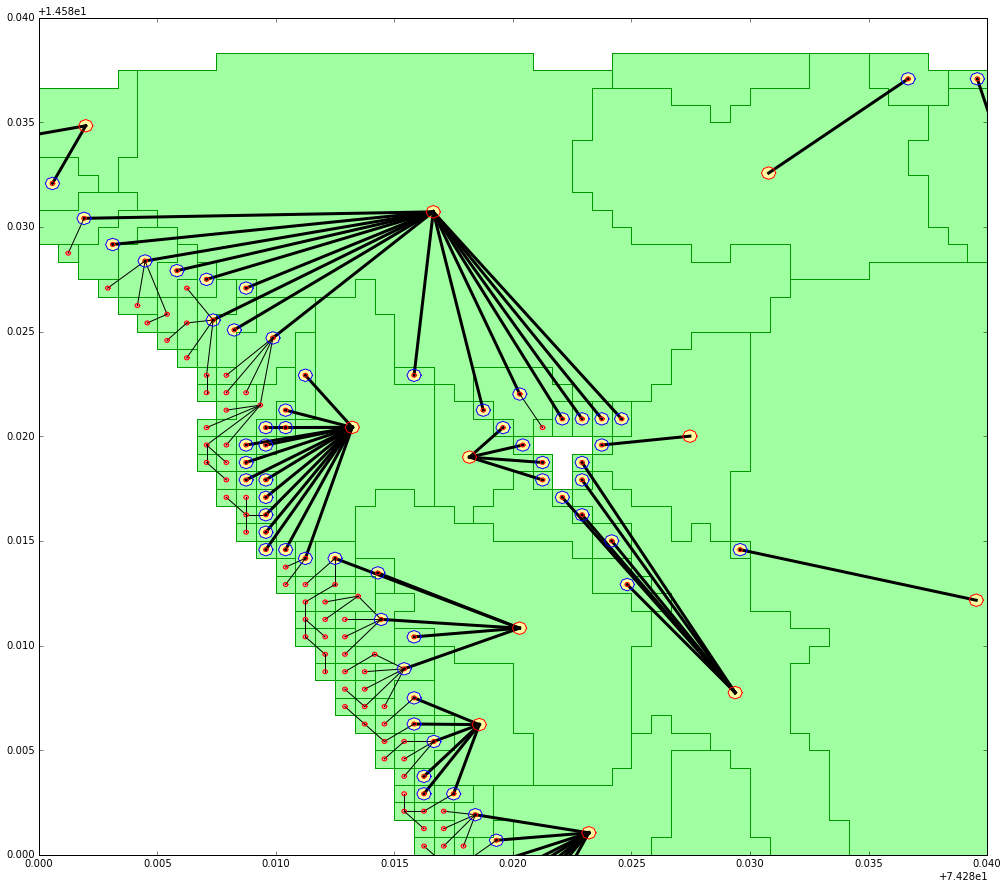

In [56]:
fig = plt.figure()
axes = plt.axes()

pylab.xlim([74.28, 74.32])
pylab.ylim([14.58, 14.62])

# axes.set_asapect('equal') # set min/max manually

draw_merged(main_catchments, to_merge1)

fig.show()

In [46]:
def draw_catchments(catchments):
    fig = plt.figure()
    axes = plt.axes()

    pylab.xlim([74.28, 74.32])
    pylab.ylim([14.58, 14.62])

    axes.set_aspect('equal') # set min/max manually

    # plot main sub-catchments
    for f in catchments:
        g = shapely.geometry.shape(f['geometry'])
    
        draw(g, outline='#009900', alpha=1.0, fill='#a0ffa0')

    plt.show()


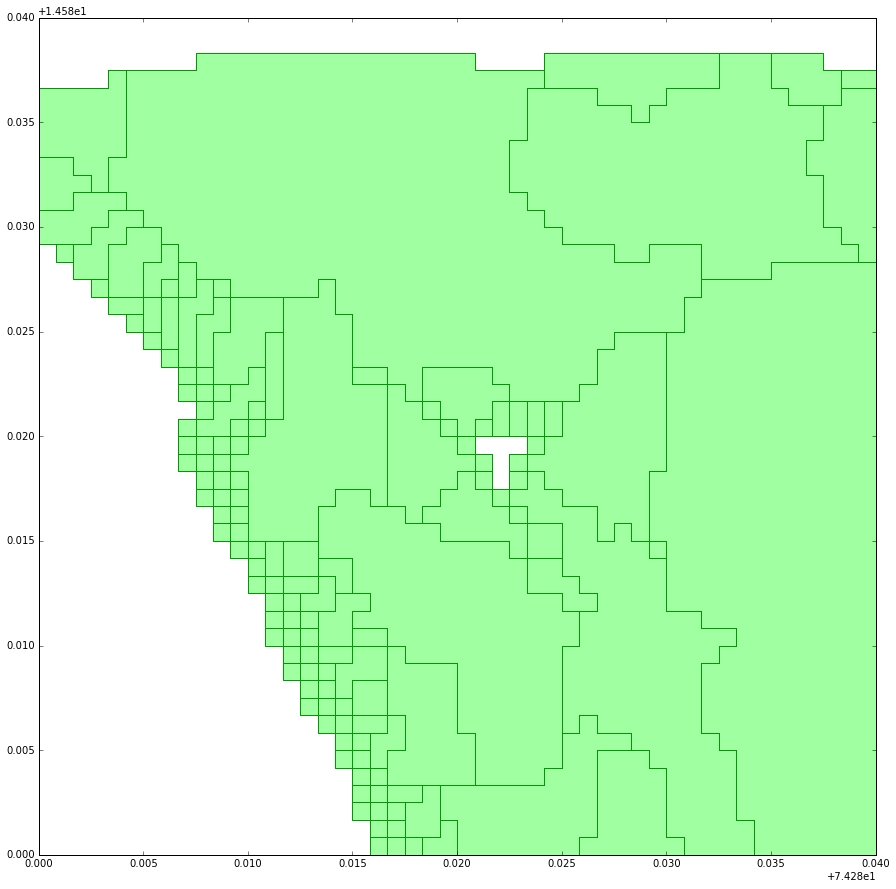

In [47]:
draw_catchments(main_catchments)

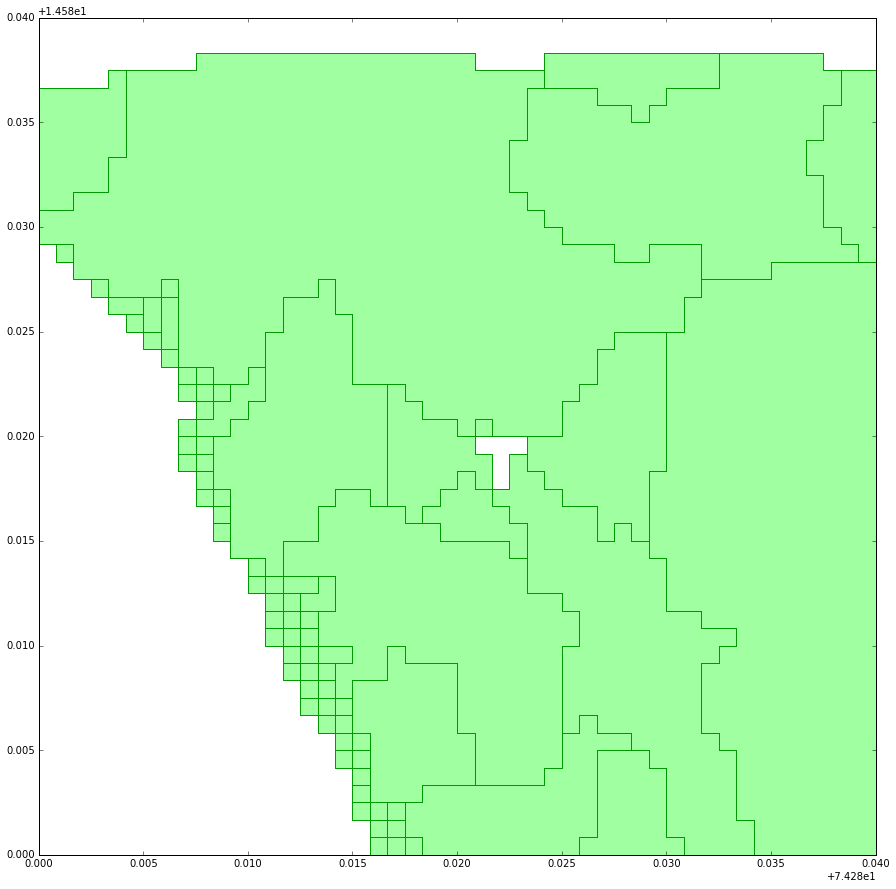

In [48]:
draw_catchments(merged1)

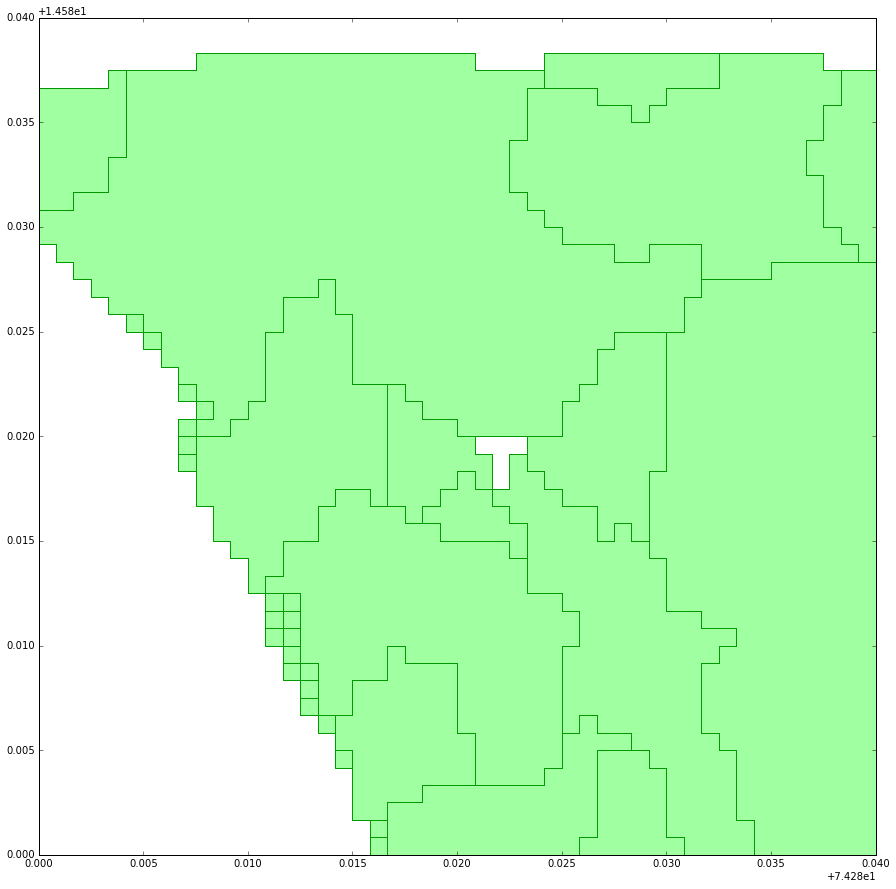

In [49]:
draw_catchments(merged2)

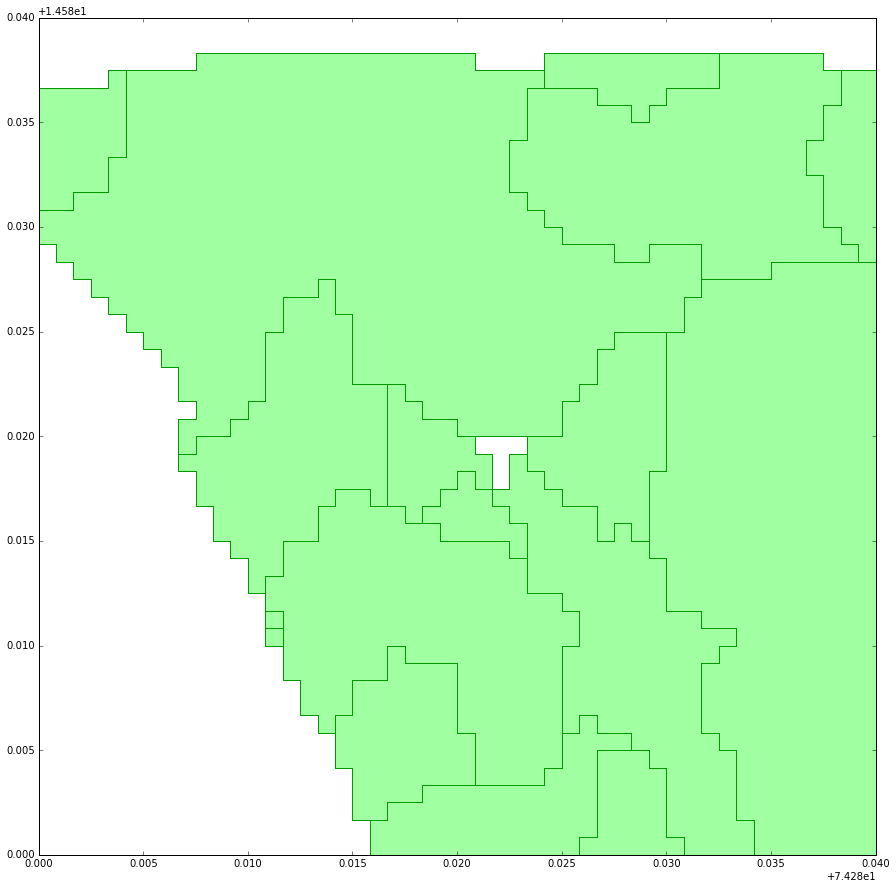

In [50]:
draw_catchments(merged3)